# Fitting and forecasting

To use `bluebonnet.forecast` in a project:

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
from scipy.misc import derivative
import pandas as pd
import matplotlib.pyplot as plt

import bluebonnet as bb
from bluebonnet.flow import (
    IdealReservoir,
    FlowProperties,
    SinglePhaseReservoir,
    RelPermParams,
)
from bluebonnet.forecast import Bounds, ForecasterOnePhase

## Forecasting with an ideal gas

In [2]:
# Get ideal gas recovery
t_end = 6
nx = 50
pressure_initial = 9000
pressure_bh = 1000
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2
res_ideal = IdealReservoir(nx, pressure_bh, pressure_initial, None)
res_ideal.simulate(time)
rf_ideal = res_ideal.recovery_factor()
rf_func = interp1d(time, rf_ideal, bounds_error=False, fill_value=(0, rf_ideal[-1]))

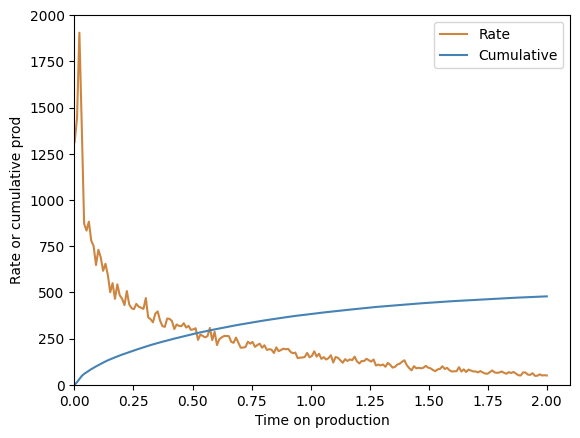

In [3]:
# Create test production to fit to
time_on_production = np.linspace(0.001, 2, 200)
tau_test = 2
M_test = 300
true_prod = M_test * derivative(rf_func, time_on_production / tau_test, dx=0.01)
production = true_prod * np.random.default_rng(42).normal(
    1, 0.1, size=len(time_on_production)
)
time_on_production = time_on_production  # [1:]
cum_production = cumtrapz(production, time_on_production, initial=0)

fig, ax = plt.subplots()
ax.plot(time_on_production, production, color="peru", label="Rate")
ax.plot(time_on_production, cum_production, color="steelblue", label="Cumulative")
ax.set(
    xlabel="Time on production",
    ylabel="Rate or cumulative prod",
    xlim=(0, None),
    ylim=(0, None),
)
ax.legend()

In [4]:
# Fit the test production
scaling_curve = ForecasterOnePhase(rf_func)

scaling_curve.fit(time_on_production, cum_production)
M_fit = scaling_curve.M_
tau_fit = scaling_curve.tau_
print(
    f"{M_fit=:.2f}, and should be {M_test}, showing the perils of integration on rapidly decreasing production"
)
print(f"{tau_fit=:.2f}, and should be {tau_test}")

M_fit=592.83, and should be 300, showing the perils of integration on rapidly decreasing production
tau_fit=2.19, and should be 2


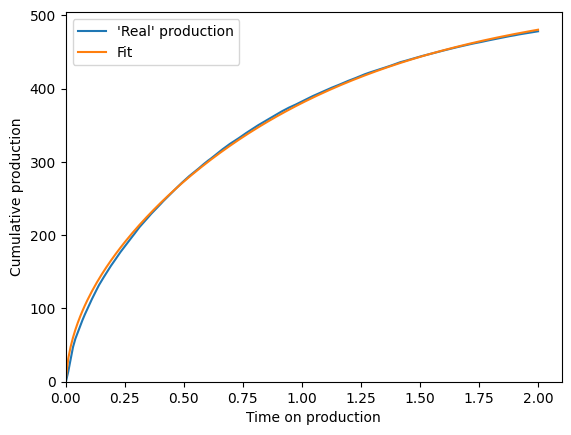

In [5]:
# Forecast cumulative production and compare fit
cum_bestfit = scaling_curve.forecast_cum(time_on_production)

fig, ax = plt.subplots()
ax.plot(time_on_production, cum_production, label="'Real' production")
ax.plot(time_on_production, cum_bestfit, label="Fit")
ax.legend()
ax.set(
    xlim=(0, None),
    ylim=(0, None),
    xlabel="Time on production",
    ylabel="Cumulative production",
);

## Forecasting with a real gas

In [6]:
pvt_gas = pd.read_csv(
    "https://raw.githubusercontent.com/frank1010111/bluebonnet/main/tests/data/pvt_gas.csv"
).rename(
    columns={
        "P": "pressure",
        "Z-Factor": "z-factor",
        "Cg": "compressibility",
        "Viscosity": "viscosity",
        "Density": "density",
    }
)
t_end = 6
nx = 60
pressure_initial = 12_000
pressure_bh = 1000
real_gas_flow_props = FlowProperties(pvt_gas, p_i=pressure_initial)
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2
res_real = IdealReservoir(nx, pressure_bh, pressure_initial, real_gas_flow_props)
res_real.simulate(time)
rf_real = res_real.recovery_factor()

In [10]:
fake_ooip = 300
fake_tau = 150
time_on_production = time[: len(time) // 2] * fake_tau
randomness = np.maximum(
    0, np.random.default_rng(42).normal(0, 0.02, size=len(time_on_production))
).cumsum()
fake_cum = rf_real[: len(time) // 2] * fake_ooip + randomness

The fitted OOIP is 343.85, and it should be over 300 (because all the randomness is positive)
The fitted tau is 162.76, and it should be near 150


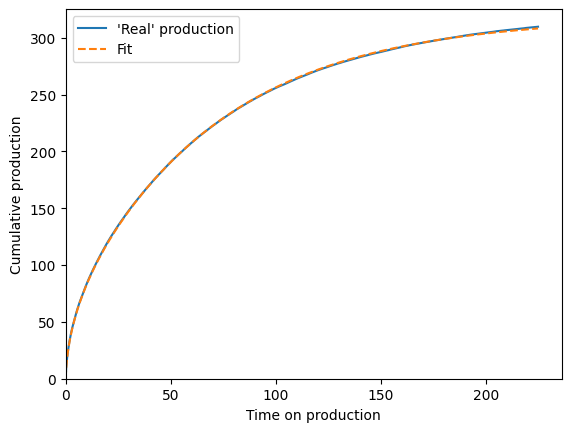

In [11]:
rf_func = interp1d(time, rf_real, bounds_error=False, fill_value=(0, rf_real[-1]))
# bounds = Bounds(M=(0,900), tau=(0.1,500))
scaling_curve = ForecasterOnePhase(rf_func)
scaling_curve.fit(time_on_production, fake_cum)
print(
    f"The fitted OOIP is {scaling_curve.M_:.2f}, and it should be over {fake_ooip} "
    "(because all the randomness is positive)\n"
    f"The fitted tau is {scaling_curve.tau_:.2f}, and it should be near {fake_tau}"
)

cum_bestfit = scaling_curve.forecast_cum(time_on_production)

fig, ax = plt.subplots()
ax.plot(time_on_production, fake_cum, label="'Real' production")
ax.plot(time_on_production, cum_bestfit, "--", label="Fit")
ax.legend()
ax.set(
    xlim=(0, None),
    ylim=(0, None),
    xlabel="Time on production",
    ylabel="Cumulative production",
);